In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.api import VAR
import utils.preprocessing as prep
from scipy.io import savemat
from scipy.linalg import sqrtm, cholesky

from src.sp_iv import SP_IV

In [2]:
# Load the data
file_path = "data/phillips_curve/monthly.csv"
data = pd.read_csv(file_path)

# Prepare data for VAR estimation
var_data, MBCshock_data = prep.clean_data(data)
# run these 2 below to save
# var_data.to_csv(r'data/var_data.csv',index=False)

# Convert DataFrame to a dictionary compatible with MATLAB

# Convert DataFrame to a NumPy array
data_matrix = MBCshock_data.to_numpy()

# Create a dictionary with the matrix and column names
matlab_dict = {"data": data_matrix, "columns": MBCshock_data.columns.to_list()}

# Save to .mat file
# savemat(r'data/MBC.mat', matlab_dict)
# MBCshock_data.to_csv(r'data/mbc_data.csv',index=False,header=False)

### REPLIC

# load mbc shock as linear combination of orthogonal shocks from Business Cycle Anatomy
file_path = "data/phillips_curve/MBC_shock2.csv"
MBCshock = pd.read_csv(file_path, header=None)

MBCshock = MBCshock.T
std_mbc_shock = 0.9
MBCshock_normalized = (MBCshock) / std_mbc_shock

MBCshock_data["core_CPI_yoy"] = (
    MBCshock_data["core_CPI_annualised_percent_change"]
    .rolling(window=12)
    .apply(prep.compute_year_on_year, args=(100,))
)
MBCshock_data["core_CPI_yoy_lagged"] = MBCshock_data["core_CPI_yoy"].shift(1).fillna(0)
MBCshock_data["core_CPI_yoy_forward"] = MBCshock_data["core_CPI_yoy"].shift(-12)
MBCshock_data["y"] = (
    MBCshock_data["core_CPI_annualised_percent_change"]
    - MBCshock_data["core_CPI_yoy_lagged"]
)
MBCshock_data["gamma_f"] = (
    MBCshock_data["core_CPI_yoy_forward"] - MBCshock_data["core_CPI_yoy_lagged"]
)

MBCshock_data.dropna(axis=0, inplace=True)

/var/folders/7l/_s01npq1225c41_90vkwthlc0000gn/T/ipykernel_27456/1609208980.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MBCshock_data["core_CPI_yoy"] = (
/var/folders/7l/_s01npq1225c41_90vkwthlc0000gn/T/ipykernel_27456/1609208980.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MBCshock_data["core_CPI_yoy_lagged"] = MBCshock_data["core_CPI_yoy"].shift(1).fillna(0)
/var/folders/7l/_s01npq1225c41_90vkwthlc0000gn/T/ipykernel_27456/1609208980.py:38: SettingWithCopyWarning: 
A value is trying to be 

In [3]:
order_dict = {
    "core_CPI_annualised_percent_change": ["target", "instruments"],
    "unemployment_rate": ["regressors", "instruments"],
    "log_industrial_production": ["controls", "instruments"],
    "PPI_commodity": ["controls", "instruments"],
    "10Y_Treasury_rate": ["controls", "instruments"],
    "3M_Treasury_rate": ["controls", "instruments"],
}

# Init model and irfs
horizons = range(0, 48, 3)
horizon = max(horizons) + 1
sp_iv = SP_IV(
    MBCshock_data[list(order_dict.keys())],
    order_dict=order_dict,
    spec="VAR",
    horizons=horizons,
    identified_shocks=MBCshock_normalized.to_numpy(),
    var_order=6,
    burn_in=12,
)
sp_iv.init_var()
sp_iv.fit_var(6, trend="n")
sp_iv.irfs_var()
sp_iv.instruments_var()

# Setup 
H = 12
N_Y = 2
N_z = 1
X, Z = sp_iv.X, sp_iv.Z
M_X = sp_iv.M_X
T = sp_iv.T

# First Stage Errors
Y_H = np.column_stack(
    [
        MBCshock_data[["unemployment_rate", "gamma_f"]]
        .iloc[h + sp_iv.start_time + 1 : h + sp_iv.T + sp_iv.start_time + 1]
        .to_numpy()
        for h in sp_iv.horizons
    ]
).T
XZ = XZ = np.vstack([X, Z])
PXZ = XZ.T @ np.linalg.inv(XZ @ XZ.T) @ XZ
MXZ = np.eye(T) - PXZ
first_stage_error = MXZ @ Y_H.T

# Forecast 
cpi_fcst = sp_iv.h_ahead_forecast_var(0, 1, 12)

# IRFs
irfs = pd.DataFrame(
    data=sp_iv.irfs.reshape(horizon, 6),
    columns=[
        "core_CPI_annualised_percent_change",
        "unemployment_rate",
        "log_industrial_production",
        "PPI_commodity",
        "10Y_Treasury_rate",
        "3M_Treasury_rate",
    ],
)
irfs["core_CPI_yoy"] = (
    irfs["core_CPI_annualised_percent_change"]
    .rolling(window=12, min_periods=1)
    .apply(prep.compute_year_on_year)
)
irfs["core_CPI_yoy_lagged"] = irfs["core_CPI_yoy"].shift(1).fillna(0)
irfs["core_CPI_yoy_forward"] = irfs["core_CPI_yoy"].shift(-12)
irfs["y"] = irfs["core_CPI_annualised_percent_change"] - irfs["core_CPI_yoy_lagged"]
irfs["gamma_f"] = irfs["core_CPI_yoy_forward"] - irfs["core_CPI_yoy_lagged"]

# KLM
ZM = np.linalg.inv(sqrtm((Z @ M_X @ Z.T)/T)) @ Z @ M_X
Theta_Y = np.hstack(
    [
        irfs["gamma_f"].iloc[horizons].to_numpy()[:H],
        irfs["unemployment_rate"].iloc[horizons].to_numpy()[:H],
    ]
).reshape(N_Y*H, 1)
Theta_y = irfs["y"].iloc[horizons].to_numpy()[:H].reshape(H, N_z)
YP = Theta_Y @ ZM 

def u(b: np.ndarray) -> np.ndarray:
    """_summary_

    Args:
        b (np.ndarray): Loadings matrix of shape N_Y x 1

    Returns:
        np.ndarray: residual of the second stage SP-IV of shape H x T
    """
    return (Theta_y - np.kron(b.T, np.eye(H)) @ Theta_Y)

u = u(np.array([2,4]))

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [15]:
first_stage_error

array([[-0.14442709,  4.32209509,  0.04336246, ..., -0.42876921,
         2.53225876, -0.59397723],
       [ 0.26292298,  3.05406197,  0.10861892, ..., -0.61694771,
         2.27734575, -0.220977  ],
       [-0.18103478,  3.13008115, -0.40020355, ..., -0.62248605,
         1.56047522,  0.64738959],
       ...,
       [-0.09720291,  0.54231008, -0.06606182, ...,  0.07965217,
         1.06708484,  0.24288606],
       [-0.06433887,  0.75132671, -0.13865252, ...,  0.21491597,
         1.04250222,  0.34154674],
       [ 0.14541735,  0.36525744, -0.17032789, ...,  0.26670184,
         0.59016787,  0.28047133]], shape=(431, 32))

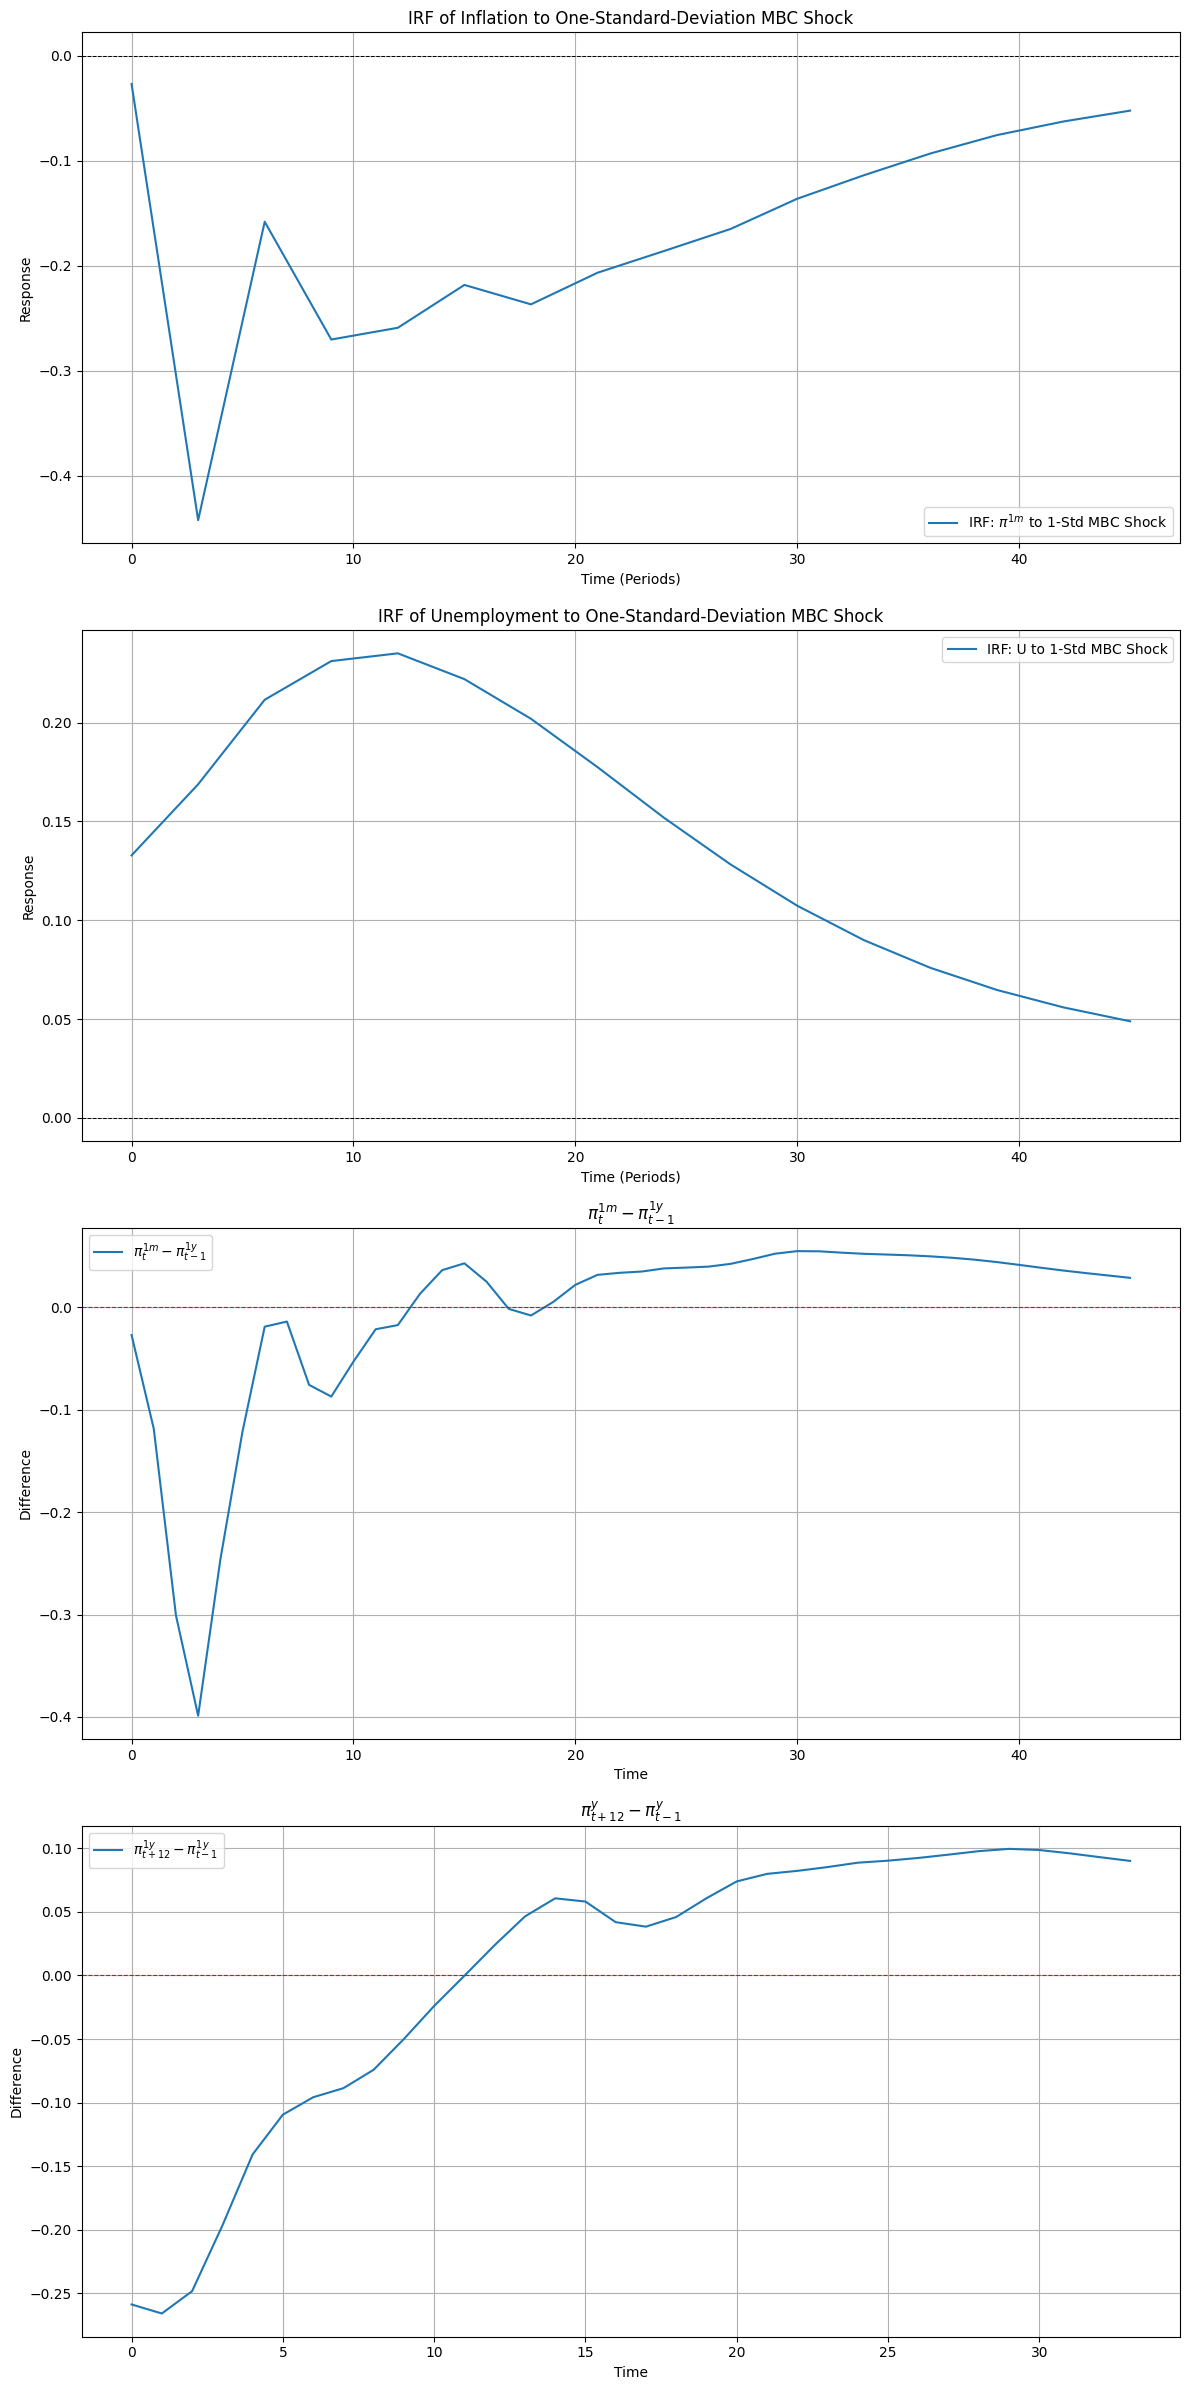

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.478
Model:                            OLS   Adj. R-squared (uncentered):              0.374
Method:                 Least Squares   F-statistic:                              4.585
Date:                Wed, 08 Jan 2025   Prob (F-statistic):                      0.0386
Time:                        03:32:18   Log-Likelihood:                          12.078
No. Observations:                  12   AIC:                                     -20.16
Df Residuals:                      10   BIC:                                     -19.19
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [12]:
irfs = pd.DataFrame(
    data=sp_iv.irfs.reshape(horizon, 6),
    columns=[
        "core_CPI_annualised_percent_change",
        "unemployment_rate",
        "log_industrial_production",
        "PPI_commodity",
        "10Y_Treasury_rate",
        "3M_Treasury_rate",
    ],
)
irfs["core_CPI_yoy"] = (
    irfs["core_CPI_annualised_percent_change"]
    .rolling(window=12, min_periods=1)
    .apply(prep.compute_year_on_year)
)
irfs["core_CPI_yoy_lagged"] = irfs["core_CPI_yoy"].shift(1).fillna(0)
irfs["core_CPI_yoy_forward"] = irfs["core_CPI_yoy"].shift(-12)
irfs["y"] = irfs["core_CPI_annualised_percent_change"] - irfs["core_CPI_yoy_lagged"]
irfs["gamma_f"] = irfs["core_CPI_yoy_forward"] - irfs["core_CPI_yoy_lagged"]
irfs_q = irfs[irfs.index % 3 == 0]
# Plot the IRF
plt.figure(figsize=(12, 24))

plt.subplot(4, 1, 1)
plt.plot(
    irfs_q["core_CPI_annualised_percent_change"],
    label=r"IRF: $\pi^{1m}$ to 1-Std MBC Shock",
)
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Time (Periods)")
plt.ylabel("Response")
plt.title("IRF of Inflation to One-Standard-Deviation MBC Shock")
plt.legend()
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(
    irfs_q["unemployment_rate"],
    label="IRF: U to 1-Std MBC Shock",
)
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Time (Periods)")
plt.ylabel("Response")
plt.title("IRF of Unemployment to One-Standard-Deviation MBC Shock")
plt.legend()
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(irfs["gamma_f"], label=r"$\pi_{t+12}^{1y} - \pi_{t-1}^{1y}$")
plt.axhline(0, color="red", linestyle="--", linewidth=0.8)
plt.title(r"$\pi_{t+12}^y - \pi_{t-1}^y$")
plt.xlabel("Time")
plt.ylabel("Difference")
plt.legend()
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(irfs["y"], label=r"$\pi_{t}^{1m} - \pi_{t-1}^{1y}$")
plt.axhline(0, color="red", linestyle="--", linewidth=0.8)
plt.title(r"$\pi_{t}^{1m} - \pi_{t-1}^{1y}$")
plt.xlabel("Time")
plt.ylabel("Difference")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

reg = smf.ols(
    "y ~ gamma_f + unemployment_rate - 1",
    data=irfs_q.iloc[:12],
).fit()
print(reg.summary())


### Data formatting for SP-IV
H = 12  # chosen horizon to keep in IRFs

In [4]:
y_H_perp

array([[ 2.00546854,  4.56728374,  3.90166214, ..., -5.09373126,
        -4.20881926, -4.99007526],
       [ 2.05591897, -1.44534523,  1.26254657, ..., -4.39041103,
        -4.58345203, -3.59122003],
       [ 5.730229  ,  3.0176924 ,  5.1460442 , ..., -4.4812262 ,
        -4.7815962 , -3.5425382 ],
       ...,
       [ 1.00622507,  0.18234677, -0.22582773, ..., -1.83344083,
        -1.57964483, -1.17416983],
       [ 0.57793408, -4.94434142,  6.76928248, ..., -2.27206922,
        -1.08187922, -1.71362822],
       [ 9.51236939,  7.92359049,  2.34380099, ..., -2.18707181,
        -1.53638281, -2.13414681]], shape=(16, 454))

<Axes: >

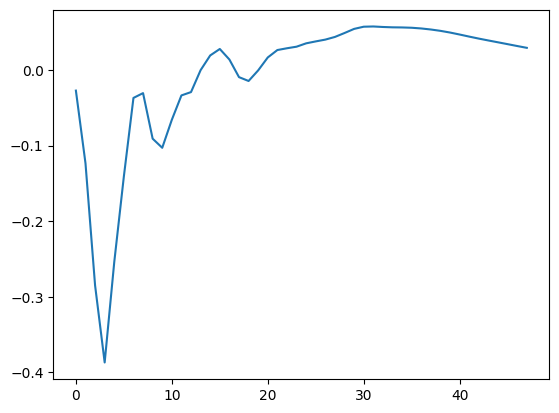

In [274]:
irfs["y"].plot()

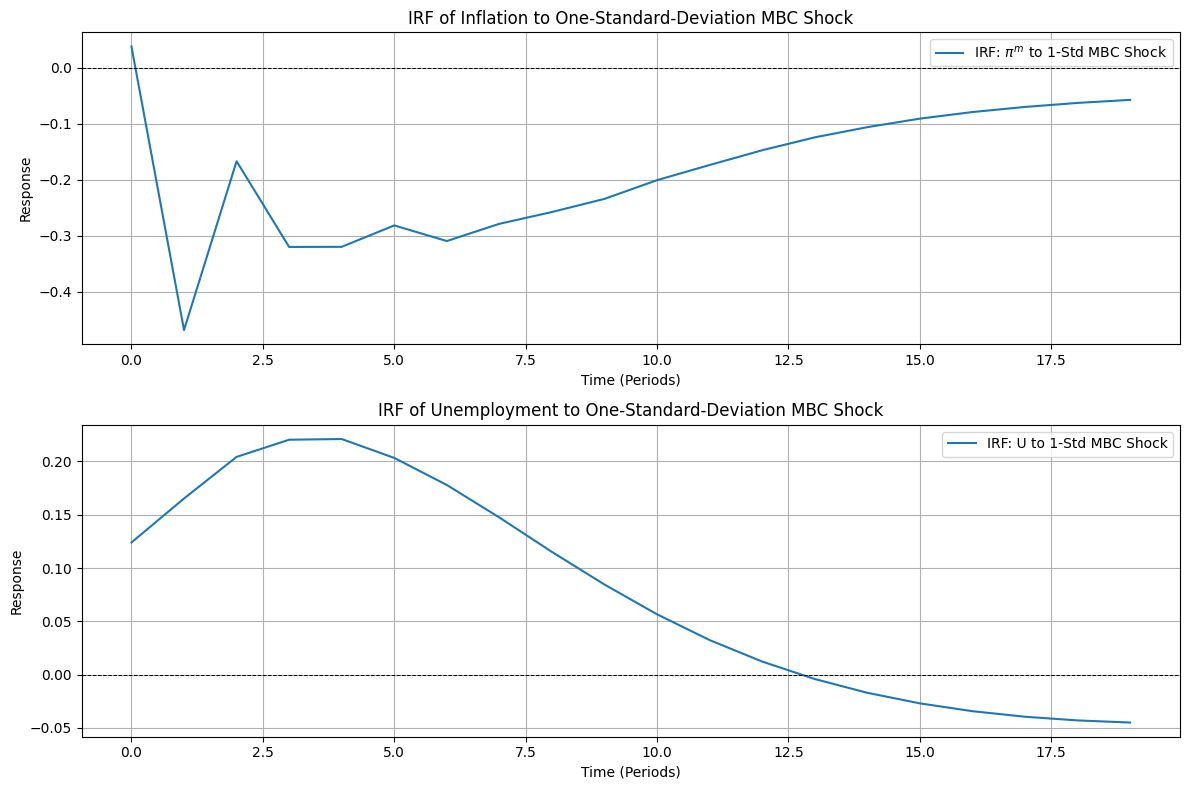

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


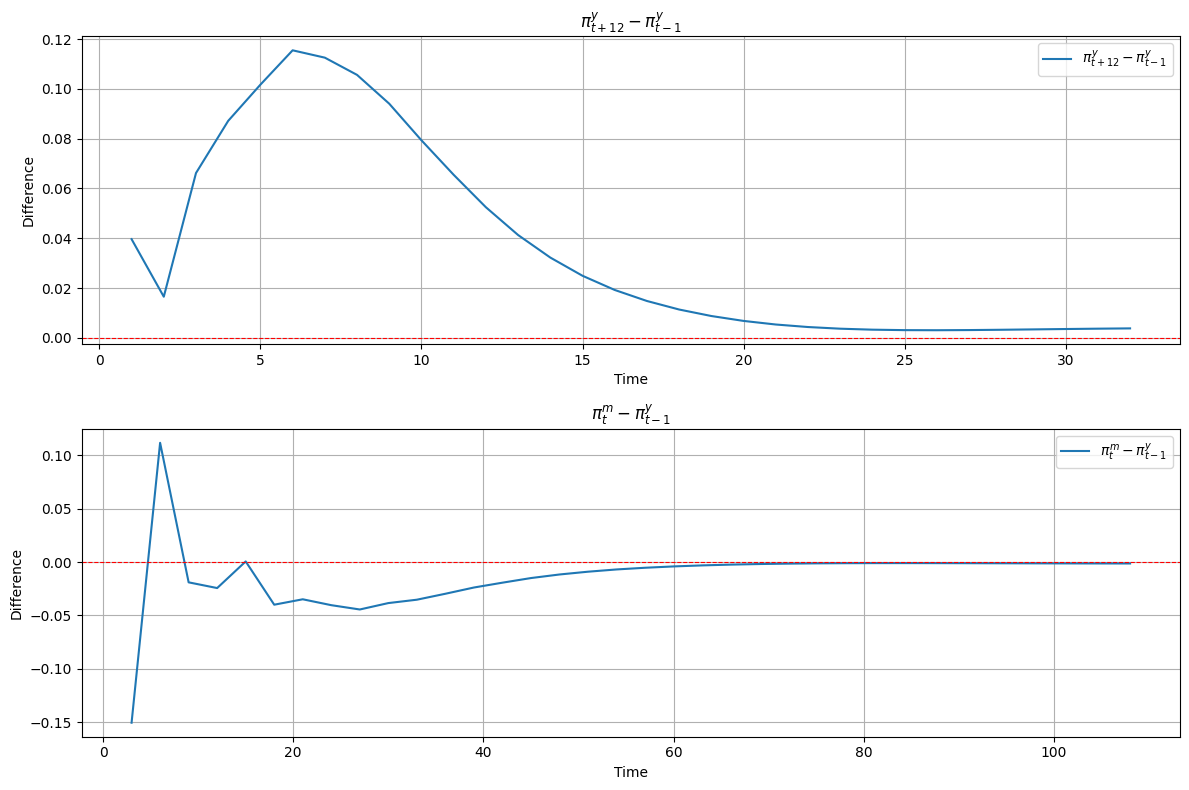

                                 OLS Regression Results                                
Dep. Variable:                      0   R-squared (uncentered):                   0.281
Model:                            OLS   Adj. R-squared (uncentered):              0.121
Method:                 Least Squares   F-statistic:                              1.760
Date:                Mon, 06 Jan 2025   Prob (F-statistic):                       0.226
Time:                        19:00:34   Log-Likelihood:                          16.422
No. Observations:                  11   AIC:                                     -28.84
Df Residuals:                       9   BIC:                                     -28.05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [8]:
# -*- coding: utf-8 -*-
"""
Created on Mon Dec 23 16:32:41 2024

@author: Maxime Coulet, Nina Stizi, Eliott Von-Pine
"""

# ==============================================================================
# Advanced Macroeconometrics - Final assignement
#
# Dynamic Identification Using System Projections on Instrumental Variables
# Working Paper No. 2204 – Dallas Fed
# ==============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import utils.preprocessing as prep
from scipy.io import savemat


### Constructing MBC shock

# Load the data
file_path = "data/phillips_curve/monthly.csv"
data = pd.read_csv(file_path)

# Prepare data for VAR estimation
var_data, MBCshock_data = prep.clean_data(data)
# run these 2 below to save
# var_data.to_csv(r'data/var_data.csv',index=False)

# Convert DataFrame to a dictionary compatible with MATLAB

# Convert DataFrame to a NumPy array
data_matrix = MBCshock_data.to_numpy()

# Create a dictionary with the matrix and column names
matlab_dict = {"data": data_matrix, "columns": MBCshock_data.columns.to_list()}

# Save to .mat file
savemat(r"data/MBC.mat", matlab_dict)
MBCshock_data.to_csv(r"data/mbc_data.csv", index=False, header=False)


### REPLIC


# load mbc shock as linear combination of orthogonal shocks from Business Cycle Anatomy
file_path = "data/phillips_curve/MBC_shock.csv"
MBCshock = pd.read_csv(file_path, header=None)
MBCshock = MBCshock.T

# Fit a VAR model
var_model = VAR(MBCshock_data)
lag_order = 6
var_results = var_model.fit(lag_order)
var_residuals = var_results.resid
sigma_u = var_results.sigma_u  # Covariance matrix of residuals

MBCshock_timeseries = np.dot(var_residuals, MBCshock)  # MBC shock time series

## construct IRFs to mbc shock
std_mbc_shock = np.sqrt(
    np.dot(np.dot(MBCshock.T, sigma_u), MBCshock)
)  # Standard deviation of MBC
exp_mbc_shock = np.mean(MBCshock)
# MBCshock_normalized = MBCshock / std_mbc_shock  # Normalize the shock vector
# MBCshock_normalized = MBCshock / 1  # don't Normalize the shock vector
MBCshock_normalized = (MBCshock - exp_mbc_shock) / 1

forecast_steps = 120
irf = var_results.irf(periods=forecast_steps)  # IRF object
irfs = irf.orth_irfs  # Shape: (forecast_steps, num_variables, num_variables)

# Adjust IRFs for the one-standard-deviation MBC shock
shock_adjusted_irfs = (
    irfs @ MBCshock_normalized.to_numpy()
)  # Weighted IRFs for the 1-std MBC shock

irf_inflation_to_mbc = shock_adjusted_irfs[:, 0][0:-1:3]
# unemployment
X_u = shock_adjusted_irfs[:, 1][0:-1:3]  # take only the 0th, 3th, 6th, ... observations

# Plot the IRF
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(range(20), irf_inflation_to_mbc[0:20], label="IRF: $\pi^m$ to 1-Std MBC Shock")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Time (Periods)")
plt.ylabel("Response")
plt.title("IRF of Inflation to One-Standard-Deviation MBC Shock")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(range(20), X_u[0:20], label="IRF: U to 1-Std MBC Shock")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Time (Periods)")
plt.ylabel("Response")
plt.title("IRF of Unemployment to One-Standard-Deviation MBC Shock")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Data formatting for SP-IV
H = 12  # chosen horizon to keep in IRFs

shock_adjusted_irfs = shock_adjusted_irfs.reshape(121, 6)
shock_adjusted_irfs = pd.DataFrame(shock_adjusted_irfs)

# unemployment
X_u = shock_adjusted_irfs[[1]]
X_u = X_u[0:-1:3]  # take only the 0th, 3th, 6th, ... observations
X_u = X_u.reset_index(drop=True)
X_u = X_u.iloc[0:H]

# dependent inflation (LHS) and independent inflation (RHS)
pi_1m = shock_adjusted_irfs[[0]]


# Function to compute pi_t^{1y} from pi_t^{1m}
def compute_year_over_year(pi_1m, window=12):
    # De-annualize monthly rates (convert to simple monthly growth rates)
    monthly_growth = (1 + pi_1m) ** (1 / 12) - 1
    T = len(monthly_growth)
    pi_1y = []

    # Compute year-over-year percent change
    for t in range(window - 1, T):  # Start from the 12th month
        cumulative_growth = np.prod(
            1 + monthly_growth[t - window + 1 : t + 1]
        )  # Cumulative product
        year_over_year = cumulative_growth - 1  # Convert to percent
        pi_1y.append(year_over_year)

    return np.array(pi_1y)


# Compute pi_t^{1y}
pi_1y = compute_year_over_year(pi_1m)


# Compute pi_{t+12}^y - pi_{t-1}^y
def compute_difference_12_minus_1(pi_1y, shift_forward=12, shift_backward=1):
    # Shift forward for pi_{t+12}^y
    pi_t_plus_12_y = np.roll(pi_1y, -shift_forward)
    pi_t_plus_12_y[-shift_forward:] = (
        np.nan
    )  # Fill last values with NaN (incomplete data)

    # Shift backward for pi_{t-1}^y
    pi_t_minus_1_y = np.roll(pi_1y, shift_backward)
    pi_t_minus_1_y[:shift_backward] = (
        np.nan
    )  # Fill first values with NaN (incomplete data)

    # Compute the difference
    difference_12_minus_1 = pi_t_plus_12_y - pi_t_minus_1_y

    return difference_12_minus_1


# Compute pi_t^m - pi_{t-1}^y
def compute_difference_t_minus_1(pi_1m, pi_1y):
    # Shift backward for pi_{t-1}^y
    pi_t_minus_1_y = np.roll(pi_1y, 1)
    pi_t_minus_1_y[:1] = np.nan  # Fill first value with NaN (incomplete data)

    # Compute the difference
    difference_t_minus_1 = pi_1m[: len(pi_1y)] - pi_t_minus_1_y

    return difference_t_minus_1


# Compute differences
pi_12_minus_1 = compute_difference_12_minus_1(pi_1y)
pi_t_minus_1 = compute_difference_t_minus_1(pi_1m, pi_1y)

# take only 0th, 3th, 6th, ... horizons
pi_12_minus_1 = pi_12_minus_1[0:-1:3]
pi_t_minus_1 = pi_t_minus_1[0:-1:3]

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(pi_12_minus_1, label="$\pi_{t+12}^y - \pi_{t-1}^y$")
plt.axhline(0, color="red", linestyle="--", linewidth=0.8)
plt.title("$\pi_{t+12}^y - \pi_{t-1}^y$")
plt.xlabel("Time")
plt.ylabel("Difference")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(pi_t_minus_1, label="$\pi_{t}^m - \pi_{t-1}^y$")
plt.axhline(0, color="red", linestyle="--", linewidth=0.8)
plt.title("$\pi_{t}^m - \pi_{t-1}^y$")
plt.xlabel("Time")
plt.ylabel("Difference")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

pi_12_minus_1 = pd.DataFrame(pi_12_minus_1)
pi_t_minus_1 = pd.DataFrame(pi_t_minus_1) * (-1)

theta_Y = pd.concat([pi_12_minus_1, X_u], axis=1)
theta_Y = theta_Y.iloc[0:H]
theta_Y = theta_Y.dropna().reset_index(drop=True)  # cut at chosen horizon
theta_Y = theta_Y.rename(columns={0: "Gamma_f", 1: "Lambda"})

pi_t_minus_1 = pi_t_minus_1.dropna().reset_index(drop=True)  # drop NA
pi_t_minus_1 = pi_t_minus_1.iloc[0:H].iloc[0 : len(theta_Y)]

### SP-IV
# Fit the regression model
model = sm.OLS(pi_t_minus_1, theta_Y).fit()
# Print a detailed summary
print(model.summary())

### KLM Statistic Test
from statsmodels.sandbox.regression.gmm import IV2SLS
from scipy.stats import chi2

Y = pi_t_minus_1  # Dependent variable

X = theta_Y["Gamma_f"]  # First-stage endogenous regressor

Z = theta_Y["Lambda"]  # Instrument

# Fit the IV regression model using two-stage least squares (2SLS)

# First-stage regression to obtain residuals
first_stage = sm.OLS(X, sm.add_constant(Z)).fit()
X_hat = first_stage.fittedvalues  # Predicted values of X
residuals = X - X_hat

# IV 2SLS Model
iv_model = IV2SLS(Y, X, Z).fit()
print(iv_model.summary())

# Compute KLM statistic
KLM_stat = len(Y) * first_stage.rsquared
print("KLM Statistic:", KLM_stat)

# Compute p-value using chi-square distribution
p_value = 1 - chi2.cdf(KLM_stat, len(Z))
print("p-value:", p_value)

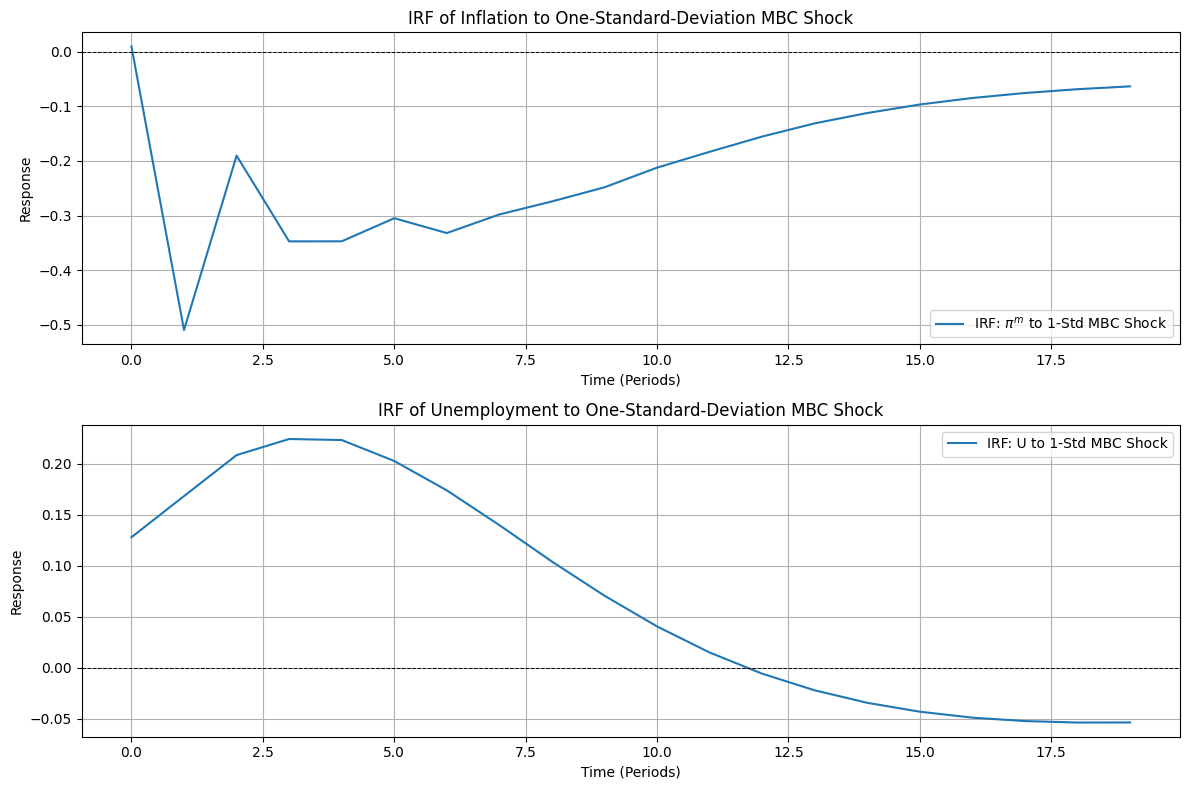

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


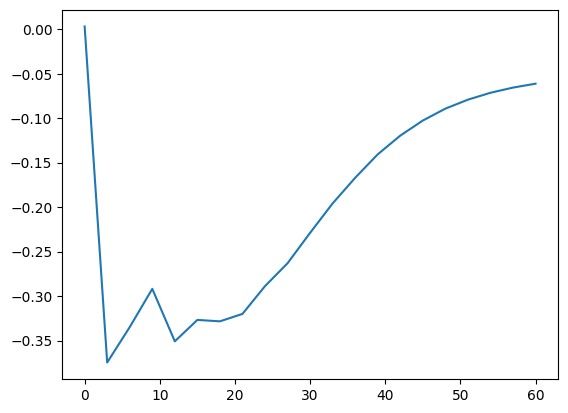

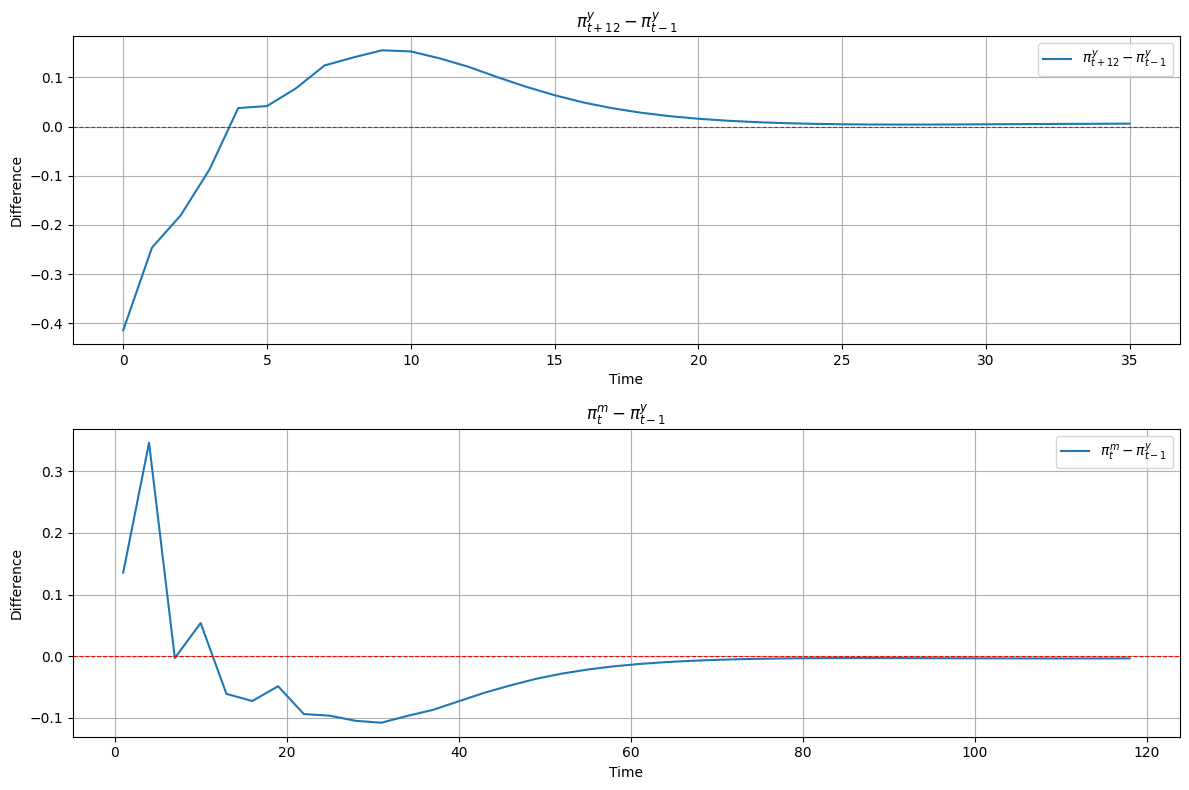

                                  OLS Regression Results                                  
Dep. Variable:     pi_{t}^m - pi_{t-1}^y   R-squared (uncentered):                   0.671
Model:                               OLS   Adj. R-squared (uncentered):              0.605
Method:                    Least Squares   F-statistic:                              10.20
Date:                   Mon, 06 Jan 2025   Prob (F-statistic):                     0.00385
Time:                           18:59:29   Log-Likelihood:                          14.121
No. Observations:                     12   AIC:                                     -24.24
Df Residuals:                         10   BIC:                                     -23.27
Df Model:                              2                                                  
Covariance Type:               nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.97

/Users/maximecoulet/miniconda3/envs/spiv_replic/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import utils.preprocessing as prep
from scipy.io import savemat
from scipy.linalg import cholesky

# import utils.KLM_plot as klmm


### Constructing MBC shock

# Load the data
file_path = "data/phillips_curve/monthly.csv"
data = pd.read_csv(file_path)

# Prepare data for VAR estimation
var_data, MBCshock_data = prep.clean_data(data)
# run these 2 below to save
# var_data.to_csv(r'data/var_data.csv',index=False)

# Convert DataFrame to a dictionary compatible with MATLAB

# Convert DataFrame to a NumPy array
data_matrix = MBCshock_data.to_numpy()

# Create a dictionary with the matrix and column names
matlab_dict = {"data": data_matrix, "columns": MBCshock_data.columns.to_list()}

# Save to .mat file
# savemat(r'data/MBC.mat', matlab_dict)
# MBCshock_data.to_csv(r'data/mbc_data.csv',index=False,header=False)

### REPLIC


# load mbc shock as linear combination of orthogonal shocks from Business Cycle Anatomy
file_path = "data/phillips_curve/MBC_shock1.csv"
MBCshock = pd.read_csv(file_path, header=None)
MBCshock = MBCshock.T

# Fit a VAR model
var_model = VAR(MBCshock_data[:len(MBCshock)-35])
lag_order = 6
var_results = var_model.fit(lag_order)
var_residuals = var_results.resid
sigma_u = var_results.sigma_u  # Covariance matrix of residuals

# MBC 1
MBCshock_timeseries = np.dot(var_residuals, MBCshock)  # MBC shock time series

cov_u = np.cov(var_residuals.T)  # Covariance matrix of residuals
cholesky_matrix = cholesky(cov_u, lower=True)  # Lower triangular matrix

# MBC 2: Recover structural shocks
structural_shocks = np.linalg.inv(cholesky_matrix) @ var_residuals.T
structural_shocks = structural_shocks.T  # Transpose to match time series format

struct_MBCshock_timeseries = np.dot(
    structural_shocks, MBCshock
)  # MBC shock time series


## construct IRFs to mbc shock
# std_mbc_shock = np.sqrt(np.dot(np.dot(MBCshock.T, sigma_u), MBCshock))  # Standard deviation of MBC
std_mbc_shock = 1
MBCshock_normalized = (
    MBCshock - np.mean(MBCshock)
) / std_mbc_shock  # Normalize the shock vector
# MBCshock_normalized = MBCshock / 1  # don't Normalize the shock vector

forecast_steps = 120
irf = var_results.irf(periods=forecast_steps)  # IRF object
irfs = irf.orth_irfs  # Shape: (forecast_steps, num_variables, num_variables)

# Adjust IRFs for the one-standard-deviation MBC shock
shock_adjusted_irfs = (
    irfs @ MBCshock_normalized.to_numpy()
)  # Weighted IRFs for the 1-std MBC shock

irf_inflation_to_mbc = shock_adjusted_irfs[:, 0][:-1:3]
# unemployment
X_u = shock_adjusted_irfs[:, 1][:-1:3]

# Plot the IRF
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(
    range(20),
    irf_inflation_to_mbc[:20],
    label="IRF: $\pi^m$ to 1-Std MBC Shock",
)
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Time (Periods)")
plt.ylabel("Response")
plt.title("IRF of Inflation to One-Standard-Deviation MBC Shock")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(range(20), X_u[:20], label="IRF: U to 1-Std MBC Shock")
plt.axhline(0, color="black", linestyle="--", linewidth=0.7)
plt.xlabel("Time (Periods)")
plt.ylabel("Response")
plt.title("IRF of Unemployment to One-Standard-Deviation MBC Shock")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Data formatting for SP-IV
H = 12  # chosen horizon to keep in IRFs

shock_adjusted_irfs = shock_adjusted_irfs.reshape(121, 6)
shock_adjusted_irfs = pd.DataFrame(shock_adjusted_irfs)

# dependent inflation (LHS) and independent inflation (RHS)
pi_1m = shock_adjusted_irfs[[0]]


# Function to compute pi_t^{1y} from pi_t^{1m}
def compute_year_over_year(pi_1m, window=12):
    # De-annualize monthly rates (convert to simple monthly growth rates)
    monthly_growth = (1 + pi_1m) ** (1 / 12) - 1
    T = len(monthly_growth)
    pi_1y = []

    # Compute year-over-year percent change
    for t in range(window - 1, T):  # Start from the 12th month
        cumulative_growth = np.prod(
            1 + monthly_growth[t - window + 1 : t + 1]
        )  # Cumulative product
        year_over_year = cumulative_growth - 1  # Convert to percent
        pi_1y.append(year_over_year)

    return np.array(pi_1y)


# Compute pi_t^{1y}
pi_1y = compute_year_over_year(pi_1m)


# Function to compute pi_t^{1y} from pi_t^{1m}
def yoy(pi_1m, window=12):
    # De-annualize monthly rates (convert to simple monthly growth rates)
    monthly_growth = (1 + pi_1m) ** (1 / 12) - 1
    T = len(monthly_growth)

    # Compute year-over-year percent change
    # Start from the 12th month
    annual_irf = np.array(
        [
            np.sum(monthly_growth[max(0, i - window + 1) : i + 1])
            for i in range(len(monthly_growth))
        ]
    )
    annual_irf = (1 + annual_irf) ** (12 / window) - 1
    return pd.DataFrame(annual_irf)


# checking function computing annual inflation IRFs from monthly annualised inflation IRFs
pi_1q = yoy(pi_1m, window=3)
plt.plot(pi_1q[:61:3])
plt.show()
# constructing irfs for annual inflation
pi_1y = yoy(pi_1m)


# Compute pi_{t+12}^y - pi_{t-1}^y
def compute_difference_12_minus_1(pi_1y, shift_forward=12, shift_backward=1):
    # Shift forward for pi_{t+12}^y
    pi_t_plus_12_y = np.roll(pi_1y, -shift_forward)
    pi_t_plus_12_y[-shift_forward:] = (
        np.nan
    )  # Fill last values with NaN (incomplete data)

    # Shift backward for pi_{t-1}^y
    pi_t_minus_1_y = np.roll(pi_1y, shift_backward)
    pi_t_minus_1_y[:shift_backward] = (
        np.nan
    )  # Fill first values with NaN (incomplete data)

    # Compute the difference
    difference_12_minus_1 = pi_t_plus_12_y - pi_t_minus_1_y

    return difference_12_minus_1[:-1]


# Compute pi_t^m - pi_{t-1}^y
def compute_difference_t_minus_1(pi_1m, pi_1y):
    # Shift backward for pi_{t-1}^y
    pi_t_minus_1_y = np.roll(pi_1y, 1)
    pi_t_minus_1_y[:1] = np.nan  # Fill first value with NaN (incomplete data)

    return pi_1m[: len(pi_1y)] - pi_t_minus_1_y


# Compute differences
pi_12_minus_1 = compute_difference_12_minus_1(pi_1y)
pi_t_minus_1 = compute_difference_t_minus_1(pi_1m, pi_1y)

# take only 0th, 3th, 6th, ... horizons
pi_12_minus_1 = pi_12_minus_1[1:-1:3]
pi_t_minus_1 = pi_t_minus_1[1:-1:3]

# Plot results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(pi_12_minus_1, label="$\pi_{t+12}^y - \pi_{t-1}^y$")
plt.axhline(0, color="red", linestyle="--", linewidth=0.8)
plt.title("$\pi_{t+12}^y - \pi_{t-1}^y$")
plt.xlabel("Time")
plt.ylabel("Difference")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(-pi_t_minus_1, label="$\pi_{t}^m - \pi_{t-1}^y$")
plt.axhline(0, color="red", linestyle="--", linewidth=0.8)
plt.title("$\pi_{t}^m - \pi_{t-1}^y$")
plt.xlabel("Time")
plt.ylabel("Difference")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

pi_12_minus_1 = pd.DataFrame(pi_12_minus_1)
pi_t_minus_1 = pd.DataFrame(pi_t_minus_1)


# unemployment
X_u = shock_adjusted_irfs[[1]]
X_u = X_u[:-1:3]
X_u = X_u.reset_index(drop=True)

# building explanatory variables
theta_Y = pd.concat([pi_12_minus_1, X_u], axis=1)
theta_Y = theta_Y.dropna().reset_index(drop=True)  # cut at chosen horizon
theta_Y = theta_Y.iloc[:H]
theta_Y = theta_Y.rename(columns={0: "pi_{t+12}^y - pi_{t-1}^y", 1: "U"})

# building dependent variable
pi_t_minus_1 = pi_t_minus_1.dropna().reset_index(drop=True)  # drop NA
pi_t_minus_1 = pi_t_minus_1.iloc[:H].iloc[: len(theta_Y)]
pi_t_minus_1 = pi_t_minus_1.rename(columns={0: "pi_{t}^m - pi_{t-1}^y"})

### SP-IV
# Fit the regression model
model = sm.OLS(pi_t_minus_1, theta_Y).fit()
# Print a detailed summary
print(model.summary())

In [23]:
shock_adjusted_irfs

,0,1,2,3,4,5
0,0.009239,0.127821,-0.004128,-0.319437,-0.096890,-0.140200
1,-0.134942,0.127353,-0.006282,-0.382199,-0.175459,-0.298132
2,-0.395644,0.146479,-0.007169,-0.551315,-0.189273,-0.357325
3,-0.509333,0.168129,-0.008280,-0.638301,-0.181164,-0.380714
4,-0.456341,0.185055,-0.008929,-0.782120,-0.192445,-0.374935
...,...,...,...,...,...,...
116,-0.035151,-0.013420,-0.000381,0.006141,-0.104737,-0.100566
117,-0.034698,-0.013182,-0.000374,0.006159,-0.103477,-0.099371
118,-0.034248,-0.012951,-0.000367,0.006177,-0.102231,-0.098185
119,-0.033799,-0.012728,-0.000361,0.006196,-0.100999,-0.097010


In [24]:
pd.DataFrame(sp_iv.irfs[:,:,0])

,0,1,2,3,4,5
0,0.009010,0.126266,-0.124778,-0.222126,-0.003263,-0.073992
1,-0.114836,0.123182,-0.191437,-0.389278,-0.005252,-0.054399
